# Klasifikasi Glaukoma pada Citra Fundus Mata menggunakan Arsitektur Convolutional Neural Network (CNN) dan Metode Ekstraksi Fitur SIFT

In [14]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
import seaborn as sns
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import joblib

# Read Dataset

In [2]:
train_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
train_path = '/kaggle/input/fundus-pytorch/train'
folder_list = os.listdir(train_path)
label_map = {
    "0":"Glaucoma Present",
    "1":"Glaucoma not Present",
}
for folder in label_map:
    img_path = os.path.join(train_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        train_df = pd.concat([train_df, new_data], ignore_index=True)

train_df[["path"]] = train_df[["path"]].astype(str)
train_df[["label"]] = train_df[["label"]].astype(str)
train_df[["class_id"]] = train_df[["class_id"]].astype(int)

In [3]:
val_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
val_path = '/kaggle/input/fundus-pytorch/val'
for folder in label_map:
    img_path = os.path.join(val_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        val_df = pd.concat([val_df, new_data], ignore_index=True)

val_df[["path"]] = val_df[["path"]].astype(str)
val_df[["label"]] = val_df[["label"]].astype(str)
val_df[["class_id"]] = val_df[["class_id"]].astype(int)

In [4]:
test_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
test_path = '/kaggle/input/fundus-pytorch/test'
for folder in label_map:
    img_path = os.path.join(test_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        test_df = pd.concat([test_df, new_data], ignore_index=True)

test_df[["path"]] = test_df[["path"]].astype(str)
test_df[["label"]] = test_df[["label"]].astype(str)
test_df[["class_id"]] = test_df[["class_id"]].astype(int)

In [5]:
# Define paths
train_path = '/kaggle/input/fundus-pytorch/train'
val_path = '/kaggle/input/fundus-pytorch/val'
test_path = '/kaggle/input/fundus-pytorch/test'

# Label mapping
label_map = {
    "0": "Glaucoma Present",
    "1": "Glaucoma not Present",
}

# Function to create a dataframe for the train, validation, and test datasets
def create_df(path, label_map):
    df = pd.DataFrame({"path": [], "label": [], "class_id": []})
    for folder in label_map:
        img_path = os.path.join(path, folder)
        jpg_list = glob(img_path + '/*.png')
        for jpg in jpg_list:
            new_data = pd.DataFrame({"path": jpg, "label": label_map[folder], "class_id": folder}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)
    df[["path"]] = df[["path"]].astype(str)
    df[["label"]] = df[["label"]].astype(str)
    df[["class_id"]] = df[["class_id"]].astype(int)
    return df

train_df = create_df(train_path, label_map)
val_df = create_df(val_path, label_map)
test_df = create_df(test_path, label_map)

# Data Preprocessing

## SIFT Feature Extraction

In [6]:
# Function to extract SIFT features from an image (fixed length and padding)
def extract_sift_features(img_path, max_keypoints=100, descriptor_size=128):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)

    # If descriptors are None or fewer keypoints than max_keypoints, pad with zeros
    if descriptors is None:
        descriptors = np.zeros((max_keypoints, descriptor_size))

    # If there are more descriptors than max_keypoints, truncate the descriptors
    if descriptors.shape[0] > max_keypoints:
        descriptors = descriptors[:max_keypoints]

    # Pad the descriptors if there are fewer keypoints than max_keypoints
    if descriptors.shape[0] < max_keypoints:
        padding = np.zeros((max_keypoints - descriptors.shape[0], descriptor_size))
        descriptors = np.vstack([descriptors, padding])

    return descriptors.flatten()

In [7]:
# Function to load images and preprocess them
def load_images(dataframe, target_size=(224, 224)):
    images = []
    labels = []
    sift_features = []

    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        img_path = row['path']
        label = row['class_id']

        # Extract SIFT features
        sift_feat = extract_sift_features(img_path)
        sift_features.append(sift_feat)

        # Load and preprocess image for CNN
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        images.append(img_array)

        labels.append(label)

    return np.array(images), np.array(labels), np.array(sift_features)

In [8]:
# Load images and SIFT features for train, validation, and test
X_train, y_train, sift_train = load_images(train_df)
X_val, y_val, sift_val = load_images(val_df)
X_test, y_test, sift_test = load_images(test_df)

100%|██████████| 2874/2874 [04:54<00:00,  9.78it/s]


## Normalization

In [9]:
# Normalize the images (scaling pixel values between 0 and 1)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

## Scaling

In [10]:
# Scale the SIFT features (standardize them)
scaler = StandardScaler()
sift_train = scaler.fit_transform(sift_train)
sift_val = scaler.transform(sift_val)
sift_test = scaler.transform(sift_test)

# Modelling & Evaluation

In [11]:
# Build the CNN model
def build_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential()

    # First convolutional block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third convolutional block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the CNN output and return
    model.add(layers.Flatten())

    return model

In [12]:
# Build CNN model for image data
cnn_model = build_cnn_model()

# Combine CNN and SIFT features
cnn_input = layers.Input(shape=(224, 224, 3))
cnn_output = cnn_model(cnn_input)

# Concatenate CNN features with SIFT features
sift_input = layers.Input(shape=(sift_train.shape[1],))  # SIFT feature size
concatenated = layers.concatenate([cnn_output, sift_input])

# Dense layers after concatenation
dense = layers.Dense(128, activation='relu')(concatenated)
output = layers.Dense(1, activation='sigmoid')(dense)

# Complete model
model = models.Model(inputs=[cnn_input, sift_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [X_train, sift_train], y_train,
    epochs=10,
    batch_size=8,
    validation_data=([X_val, sift_val], y_val)
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_test, sift_test], y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 598s 552ms/step - accuracy: 0.6024 - loss: 1.0395 - val_accuracy: 0.6396 - val_loss: 0.6160
Epoch 2/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 601s 558ms/step - accuracy: 0.7027 - loss: 0.5808 - val_accuracy: 0.6915 - val_loss: 0.5655
Epoch 3/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 583s 541ms/step - accuracy: 0.7112 - loss: 0.5628 - val_accuracy: 0.7844 - val_loss: 0.4687
Epoch 4/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 583s 541ms/step - accuracy: 0.7916 - loss: 0.4570 - val_accuracy: 0.8307 - val_loss: 0.4090
Epoch 5/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 590s 547ms/step - accuracy: 0.8103 - loss: 0.4167 - val_accuracy: 0.8035 - val_loss: 0.4254
Epoch 6/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 583s 541ms/step - accuracy: 0.8363 - loss: 0.3653 - val_accuracy: 0.8185 - val_loss: 0.3527
Epoch 7/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 591s 548ms/step - accuracy: 0.8490 - loss: 0.3308 - val_accuracy: 0.8719 - val_loss: 0.2830
Epoch 8/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 581s 539ms/step - ac

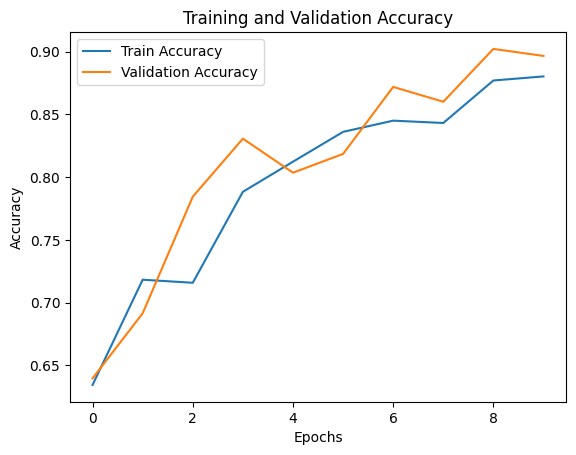

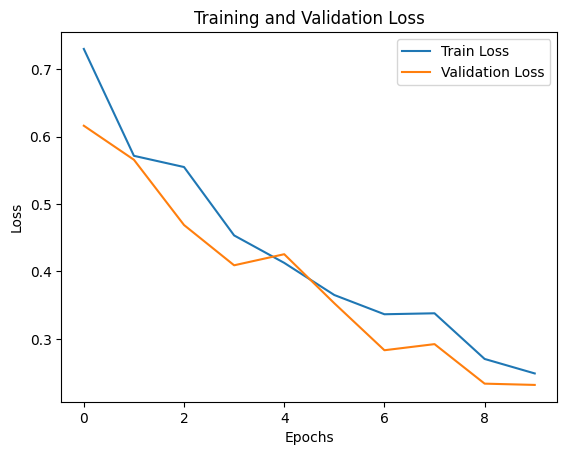

In [13]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Predict on the test set
y_pred = model.predict([X_test, sift_test])

# Convert probabilities to class labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype(int)

# Print classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))

90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 557ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1754
           1       0.82      0.93      0.87      1120

    accuracy                           0.89      2874
   macro avg       0.89      0.90      0.89      2874
weighted avg       0.90      0.89      0.90      2874



# Export Scaler & Model

In [15]:
# Simpan scaler dalam format .pkl
joblib.dump(scaler, 'sift_scaler.pkl')

['sift_scaler.pkl']

In [16]:
# Simpan model dalam format .h5
model.save('glaucoma_model.h5')